<a href="https://colab.research.google.com/github/ir1ss/DeepLearningWithPython/blob/main/transferDog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
from keras import backend as K
from keras.layers import Dense, Activation, Dropout, BatchNormalization, Input, Flatten, Conv2D, MaxPooling2D, Lambda, UpSampling2D, Concatenate
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.initializers import he_normal
from keras.preprocessing.image import ImageDataGenerator
import os
import shutil

In [ ]:
# 解压缩
!unzip /content/drive/MyDrive/dog-breed-identification.zip

In [ ]:
# 查看前五个标签 注：labels.csv中存储的是所有图片的编码
labels = pd.read_csv('/content/labels.csv')
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [ ]:
# 统计标签总量
classes = np.unique(labels.breed)
classes_num = classes.size
classes_num

120

In [ ]:
# 定义一下训练集目录+统计目录中文件数量
train_dir = '/content/train'  
images_names = os.listdir(train_dir)  
images_num = len(images_names)
print(f'Number of images: {images_num}')  

Number of images: 10222


In [ ]:
# 新开文件夹，方便划分train,val,test
new_train_dir = '/content/new_train/'
new_test_dir = '/content/new_test/'
new_valid_dir = '/content/new_valid/'

# 创建
!mkdir new_train_dir
!mkdir new_test_dir
!mkdir new_valid_dir


mkdir: cannot create directory ‘new_train_dir’: File exists
mkdir: cannot create directory ‘new_test_dir’: File exists
mkdir: cannot create directory ‘new_valid_dir’: File exists


In [ ]:
# 为每个物种都创建一个文件夹，注：mkdir只能在一层子目录的地址中创新目录，要用makedirs
for sub_dir in classes:
  os.makedirs(new_train_dir+sub_dir)
  os.makedirs(new_test_dir+sub_dir)
  os.makedirs(new_valid_dir+sub_dir)

In [ ]:
# 查看创建情况
!ls $new_train_dir

affenpinscher			italian_greyhound
afghan_hound			japanese_spaniel
african_hunting_dog		keeshond
airedale			kelpie
american_staffordshire_terrier	kerry_blue_terrier
appenzeller			komondor
australian_terrier		kuvasz
basenji				labrador_retriever
basset				lakeland_terrier
beagle				leonberg
bedlington_terrier		lhasa
bernese_mountain_dog		malamute
black-and-tan_coonhound		malinois
blenheim_spaniel		maltese_dog
bloodhound			mexican_hairless
bluetick			miniature_pinscher
border_collie			miniature_poodle
border_terrier			miniature_schnauzer
borzoi				newfoundland
boston_bull			norfolk_terrier
bouvier_des_flandres		norwegian_elkhound
boxer				norwich_terrier
brabancon_griffon		old_english_sheepdog
briard				otterhound
brittany_spaniel		papillon
bull_mastiff			pekinese
cairn				pembroke
cardigan			pomeranian
chesapeake_bay_retriever	pug
chihuahua			redbone
chow				rhodesian_ridgeback
clumber				rottweiler
cocker_spaniel			saint_bernard
collie				saluki
curly-coated_retriever		samoyed
dandie_di

In [ ]:
type(labels)

pandas.core.frame.DataFrame

In [ ]:
# 给每个id后面加jpg，便于与实际图片对应 注：copy是pandas中dataframe类的方法，deep=True表示复制样本进行copy，而不是引用的copy
labels_jpg = labels.copy(deep=True)
labels_jpg['id'] += '.jpg'  

In [ ]:
# 给图片名称分组，结果为字典，有三个键值 id breed和该品种所有图片的图片名
grouped_ids = labels_jpg.groupby('breed')['id'].apply(list).to_dict()
print(classes[0], grouped_ids[classes[0]])

affenpinscher ['00ca18751837cd6a22813f8e221f7819.jpg', '01268f0007876a692907bda89468184c.jpg', '0162107acd8f2588c0944b791d61bb0c.jpg', '040fef64640b89c53f161b6c5215b78b.jpg', '0484a6cc686a07e1edacd0fb44b1d965.jpg', '100f347ec78a42a9e7c2418e4beb3f6a.jpg', '106d7e0df869e7ba9f6d16c5f77ddfb8.jpg', '10edc6f98c2423e4e195e09a86b0d292.jpg', '11b60d8d86f14a601ca290909a17cbc6.jpg', '18b4e732c105272f40956c2f85813bcb.jpg', '19a8c1698819d382c3ead14bdc1a360b.jpg', '19de1db12b3ddc7f2af6d9453c977083.jpg', '1a012faf98b32039adc17ee708bcb360.jpg', '1aa98488ce65f9b57b468ccde4f1cad8.jpg', '1ee0c041d15647e3909625eba419f153.jpg', '20430175869defec1722d3432f42ebd7.jpg', '21cc2409dba86b22048915de56ba1698.jpg', '263a1b1fa0cafa212f6c34c7bf693b57.jpg', '32249ae4f7590aede350e2b08b322ac4.jpg', '38e9c2d8f4f1a26685e80adf8f1b927c.jpg', '42404238339c427c0fb830da89885d5e.jpg', '482e38adec95d535eb4677504a82e1a4.jpg', '4a6cff93d44190c7e2410799f729a4d0.jpg', '4ca6732ea8c9a354d28b5e8fc71385e4.jpg', '4cb48a54b94e4c7dcf9798f7

In [ ]:
# 百分之10分为测试集，百分之20分为验证集
test_split = 0.1
valid_split = 0.2

In [ ]:
train_size = 0
valid_size = 0
test_size = 0
for breed_idx, (breed, breed_images) in enumerate(grouped_ids.items()):
  for img in breed_images:
    rnd_prob = np.random.rand()  # 随机生成0的1的值，这样通过这个值与前面设置test和valid的百分数对比可实现随机划分
    if rnd_prob <= test_split: 
      shutil.copy(train_dir+'/'+img, new_test_dir+'/'+breed) 
      test_size += 1
    elif rnd_prob <= (test_split + valid_split):
      shutil.copy(train_dir+'/'+img, new_valid_dir+'/'+breed)
      valid_size += 1
    else:
      shutil.copy(train_dir+'/'+img, new_train_dir+'/'+breed)
      train_size += 1
            
  clear_output(wait=True)
  print(f'处理好了第 {breed_idx+1} 种，总共 {classes_num} 种。当前品种: {breed}')

处理好了第 120 种，总共 120 种。当前品种: yorkshire_terrier


In [ ]:
print(train_size, valid_size, test_size)

7115 2105 1002


In [ ]:
# 宽 高 通道数
width, height, channels = 512, 512, 3

In [ ]:
images_samples = np.zeros((4, height, width, 3), dtype=float)
samples_labels = []


In [ ]:
images_samples

In [ ]:
# 检查一下图片标记情况，随机查看四张
rnd_indexes = np.random.randint(0, images_num, 4) # 在[0, images_num)中随机4个数
rnd_indexes

array([4933, 3404, 1747, 2423])

In [ ]:
for i, rnd_index in enumerate(rnd_indexes):
  img_filename = images_names[rnd_index]
  img_id = img_filename[:-4]
  img_bgr = cv2.imread(train_dir + '/' + img_filename) # 读取图片的b g r
  images_samples[i] = cv2.resize(src=img_bgr[:, :, [2, 1, 0]], dsize=(width, height)) / 255 # 2 1 0是换顺序，说明是BGR。除255是为了对应imshow的数值范围
  img_label = labels.breed[labels.id == img_id].values[0] # 获取id
  samples_labels.append(img_label)

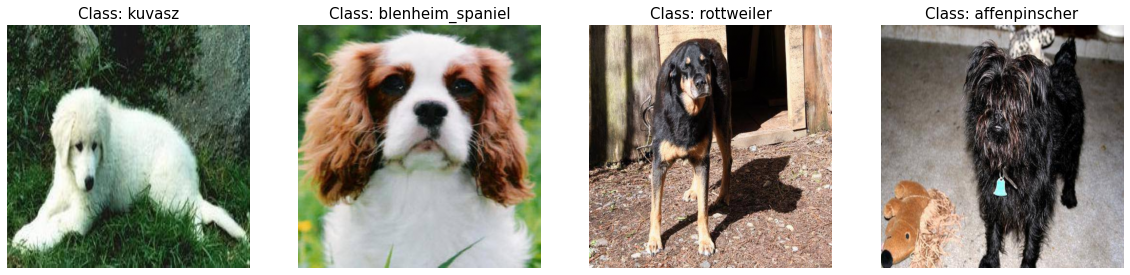

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, img, label in zip(axs.ravel(), images_samples, samples_labels):
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Class: {label}', size=15);

In [ ]:
# 图像增强
norm_factor = 1 / 255   # 输入网络图片的数值范围，目的是保证梯度小

transform_params = {
    'featurewise_center': False,
    'featurewise_std_normalization': False,
    'samplewise_center': False,
    'samplewise_std_normalization': False,
    'rotation_range': 30, 
    'width_shift_range': 0.15,
    'height_shift_range': 0.15,
    'horizontal_flip': True,
    'rescale': norm_factor
}
img_gen = ImageDataGenerator(**transform_params) # 用于训练集的迭代器，将数据增强参数带入

In [ ]:
img_feed = ImageDataGenerator(rescale=1/255) # 用于验证集的迭代器，不参与训练所以只需数值缩放，无需数据增强

In [ ]:
# 该函数用于在训练过程中绘图保存结果
class Plotter(Callback):
  def plot(self):  # Updates the graph
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
        
    ax1.plot(self.epochs, self.losses, label='train_loss')
    ax1.plot(self.epochs, self.val_losses, label='val_loss')
        
    ax2.plot(self.epochs, self.acc, label='train_acc')
    ax2.plot(self.epochs, self.val_acc, label='val_acc')
    
    ax1.set_title(f'Loss vs Epochs')
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
        
    ax2.set_title(f'Accuracy vs Epochs')
    ax2.set_xlabel("Epoches")
    ax2.set_ylabel("Accuracy")
        
    ax1.legend()
    ax2.legend()
    plt.show()
        
    print(f'Epoch #{self.epochs[-1]+1} >> train_acc={self.acc[-1]*100:.3f}%, train_loss={self.losses[-1]:.5f}')
    print(f'Epoch #{self.epochs[-1]+1} >> val_acc={self.val_acc[-1]*100:.3f}%, val_loss={self.val_losses[-1]:.5f}')
        
    def on_train_begin(self, logs={}):
      self.losses = []
      self.val_losses = []
      self.epochs = []
      self.batch_no = []
      self.acc = []
      self.val_acc = []
    
    def on_epoch_end(self, epoch, logs={}):
      self.losses.append(logs.get('loss'))
      self.val_losses.append(logs.get('val_loss'))
      self.acc.append(logs.get('acc'))
      self.val_acc.append(logs.get('val_acc'))
      self.epochs.append(epoch)
      self.plot()  # update the graph
        
    def on_train_end(self, logs={}):
      self.plot()
        
    def load_plot_data(self, data):
      self.losses, self.val_losses, self.epochs, self.batch_no, self.acc, self.val_acc = data
    
    def get_plot_data(self):
      return [self.losses, self.val_losses, self.epochs, self.batch_no, self.acc, self.val_acc]
               
plotter = Plotter()

In [ ]:
# 用来在验证集准确度不怎么提升时动态降低学习率，这样可以驱使网络继续收敛
plateau_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=1, min_lr=1e-20)

In [ ]:
# 监测泛化能力最好的权重
e_stop = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

In [ ]:
callbacks = [plotter, plateau_reduce, e_stop]

In [ ]:
# 定义一个设置全连接层参数的函数
def dense_block(x, neurons, layer_no):
  x = Dense(neurons, kernel_initializer=he_normal(layer_no), name=f'topDense{layer_no}')(x)
  x = Activation('relu', name=f'Relu{layer_no}')(x)
  x = BatchNormalization(name=f'BatchNorm{layer_no}')(x)
  x = Dropout(0.5, name=f'Dropout{layer_no}')(x)
  return x

In [ ]:
# 定义设置网络的函数
def create_model(shape):
  input_layer = Input(shape, name='input_layer')  
    
  # 以InceptionResNetV2为卷积基
  incep_res = InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=input_layer)
  for layer in incep_res.layers:
      layer.trainable = False # 先冻结卷积基的每一层

  pool = MaxPooling2D(pool_size=[3, 3], strides=[3, 3], padding='same')(incep_res.output)
  flat1 = Flatten(name='Flatten1')(pool)
  flat1_bn = BatchNormalization(name='BatchNormFlat')(flat1)
 
  dens1 = dense_block(flat1_bn, neurons=512, layer_no=1)
  dens2 = dense_block(dens1, neurons=512, layer_no=2)
  dens3 = dense_block(dens2, neurons=1024, layer_no=3)
    
  dens_final = Dense(classes_num, name='Dense4')(dens3)
  output_layer = Activation('softmax', name='Softmax')(dens_final) # 最后一层全连接层要用softmax激活，所以不用dense_block函数
    
  model = Model(inputs=[input_layer], outputs=[output_layer])

  return model

In [ ]:
height, width, channels_num = 512, 512, 3
learning_rate = 0.004
epochs = 15
batch_size = 32 

In [ ]:
model = create_model((height, width, channels_num))
optimizer = Adam(learning_rate)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['acc'])

219062272/219055592 [==============================] - 2s 0us/step


In [ ]:
train_gen = img_gen.flow_from_directory(directory=new_train_dir, target_size=(height, width), color_mode='rgb', classes=list(classes), class_mode='categorical', batch_size=batch_size, shuffle=True, interpolation='nearest')

Found 7115 images belonging to 120 classes.


In [ ]:
valid_gen = img_feed.flow_from_directory(directory=new_valid_dir, target_size=(height, width), color_mode='rgb', classes=list(classes), class_mode='categorical', batch_size=batch_size, shuffle=True, interpolation='nearest')

Found 2105 images belonging to 120 classes.


In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, epochs=epochs, 
                steps_per_epoch=train_size//batch_size + 1, 
                validation_steps=valid_size//batch_size + 1, callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
223/223 [==============================] - 502s 2s/step - loss: 5.3331 - acc: 0.1041 - val_loss: 0.8418 - val_acc: 0.7834
Epoch 2/15
223/223 [==============================] - 464s 2s/step - loss: 1.9908 - acc: 0.5540 - val_loss: 0.6988 - val_acc: 0.8437
Epoch 3/15
223/223 [==============================] - 464s 2s/step - loss: 1.4126 - acc: 0.6737 - val_loss: 0.5426 - val_acc: 0.8836
Epoch 4/15
223/223 [==============================] - 465s 2s/step - loss: 1.0897 - acc: 0.7261 - val_loss: 0.4434 - val_acc: 0.9026
Epoch 5/15
223/223 [==============================] - 461s 2s/step - loss: 0.9535 - acc: 0.7635 - val_loss: 0.5565 - val_acc: 0.8812
Epoch 6/15
223/223 [==============================] - 457s 2s/step - loss: 0.8556 - acc: 0.7777 - val_loss: 0.4572 - val_acc: 0.8855
Epoch 7/15
223/223 [==============================] - 491s 2s/step - loss: 0.8025 - acc: 0.7892 - val_loss: 0.4565 - val_acc: 0.8874
Epoch 8/15
223/223 [==============================] - 480s 2s/step - 

In [ ]:
test_gen = ImageDataGenerator(rescale=1/255)
test_flow = test_gen.flow_from_directory(new_test_dir,
        target_size=(512, 512),
        batch_size=1,
        shuffle=False)

Found 1002 images belonging to 120 classes.


In [ ]:
metrics = model.evaluate_generator(test_flow, steps=test_size)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [ ]:
m_names = model.metrics_names
print(f'{m_names[0]} = {metrics[0]}\n{m_names[1]} = {metrics[1]}')

loss = 0.41798946261405945
acc = 0.9021956324577332


In [ ]:
model.save('final_model.h5')

In [ ]:
model2 = Sequential()

In [2]:
from keras import models

In [3]:
model = models.Sequential()

In [4]:
from keras import layers

In [5]:
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [6]:
model.save('/content/drive/MyDrive/haha.h5')

In [7]:
from keras.models import load_model

In [8]:
modelll = models.load_model('/content/drive/MyDrive/final_model.h5')

In [9]:
modelll.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 255, 255, 32) 864         input_layer[0][0]                
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 255, 255, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 255, 255, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________